## In this notebook we train a segmentation NN to classify different car parts in images, and use it alongside the SLIC algorithm and a ruleset we defined to detect car orientation. The segmentation data was taken from https://github.com/dsmlr/Car-Parts-Segmentation

In [3]:
! git clone https://github.com/dsmlr/Car-Parts-Segmentation.git

fatal: destination path 'Car-Parts-Segmentation' already exists and is not an empty directory.


In [2]:
import json 
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2DTranspose, concatenate
import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.layers import BatchNormalization, Add, Subtract, ReLU, Dropout
import pandas as pd
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import cv2 
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import color
%matplotlib inline

In [4]:
with open('/content/Car-Parts-Segmentation/trainingset/annotations.json') as f:
    annotations = json.load(f)

IMG_FOLDER = '/content/Car-Parts-Segmentation/trainingset/JPEGImages'

with open('/content/Car-Parts-Segmentation/testset/annotations.json') as f:
    annotations_test = json.load(f)

IMG_FOLDER_test = '/content/Car-Parts-Segmentation/testset/JPEGImages'


In [5]:
category_dict = {entry['name'] : entry['id'] - 1 for entry in annotations['categories']}
rev_category_dict = {v : k for k, v in category_dict.items()}
category_dict

{'_background_': 0,
 'back_bumper': 1,
 'back_glass': 2,
 'back_left_door': 3,
 'back_left_light': 4,
 'back_right_door': 5,
 'back_right_light': 6,
 'front_bumper': 7,
 'front_glass': 8,
 'front_left_door': 9,
 'front_left_light': 10,
 'front_right_door': 11,
 'front_right_light': 12,
 'hood': 13,
 'left_mirror': 14,
 'right_mirror': 15,
 'tailgate': 16,
 'trunk': 17,
 'wheel': 18}

In [6]:
coco, coco_test = COCO('/content/Car-Parts-Segmentation/trainingset/annotations.json'), COCO('/content/Car-Parts-Segmentation/testset/annotations.json')

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
def get_img_and_mask(img_num, coco, IMG_FOLDER, img_res_x, img_res_y, train):
    """
    Generates labeled images for training and testing, recieves an image
    and returns the image and the coresponding labeled mask
    """
    img_dir = IMG_FOLDER
    if train:
        image_id = img_num
    elif not train:
        image_id = img_num + 400
    img = coco.imgs[image_id]
    image = np.array(Image.open(os.path.join(img_dir, img['file_name'].lstrip('/JPEGImages'))))
    img_w, img_h = image.shape[0], image.shape[1]
    image = tf.image.resize(image, (img_res_x, img_res_y))
    cat_ids = coco.getCatIds()
    anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(anns_ids)
    mask = np.zeros((img_w, img_h), int)
    # Iterate over each annotation, value in final mask is assigned category_id
    for i in range(len(anns)):
        cat_mask = coco.annToMask(anns[i])
        cat_mask[cat_mask == 1] = anns[i]['category_id']
        mask = np.maximum(mask, cat_mask)
    mask = cv2.resize(mask, (img_res_x, img_res_y), interpolation = cv2.INTER_NEAREST)
    return image, mask

In [34]:
X, y = [], []

# Get images from training data

for i in range(399):
    img, mask = get_img_and_mask(i + 1, coco, IMG_FOLDER, 128, 128, train = True)
    X.append(img) 
    y.append(mask)
    

# Get images from testing data

for i in range(99):
    img, mask = get_img_and_mask(i + 1, coco_test, IMG_FOLDER_test, 128, 128, train = False)
    X.append(img) 
    y.append(mask)
    
    

    
    
    


In [9]:
X = np.array(X)
y = np.array(y)


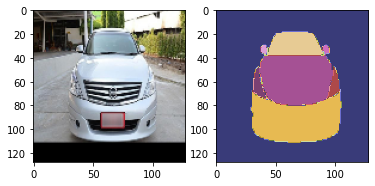

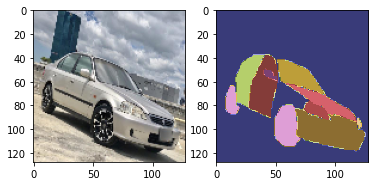

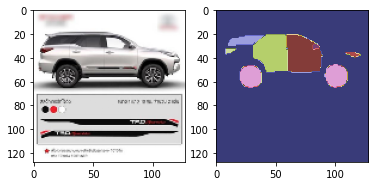

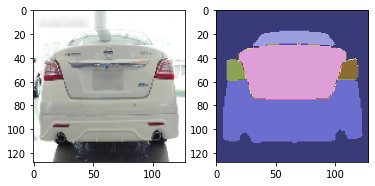

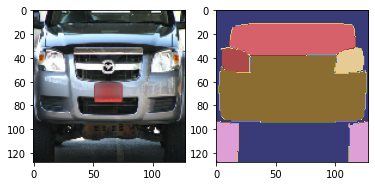

In [36]:
# Sanity check
def print_example(image_num):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(X[image_num] / 255.)
    axs[1].imshow(y[image_num], cmap = 'tab20b')


for i in range(5):
    n = np.random.randint(1, 498)
    print_example(n)

# Preparing the data for modeling 

In [11]:
X = X / 255.

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state = 1)

In [13]:
print('Shape of X_train is:', x_train.shape)
print('Shape of y_train is:', y_train.shape)
print('Shape of X_val is:', x_val.shape)
print('Shape of y_val is:', y_val.shape)
print('Shape of X_test is:', x_test.shape)
print('Shape of y_test is:', y_test.shape)

Shape of X_train is: (398, 128, 128, 3)
Shape of y_train is: (398, 128, 128)
Shape of X_val is: (50, 128, 128, 3)
Shape of y_val is: (50, 128, 128)
Shape of X_test is: (50, 128, 128, 3)
Shape of y_test is: (50, 128, 128)


# Preparing the network


### The network is a U-Net based of the example network from (https://www.tensorflow.org/tutorials/images/segmentation)

In [14]:
# Get required files / models for final network

!pip install git+https://github.com/tensorflow/examples.git

from tensorflow_examples.models.pix2pix import pix2pix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-e0nqobf2
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-e0nqobf2
  Created wheel for tensorflow-examples: filename=tensorflow_examples-3712020b6cb16bc5b932c8b782461bf77c8fea80_-py3-none-any.whl size=299670 sha256=8ad7232aeda72cd29712fa1d8d63935173c0d2032e5481857325bd17fd2734fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-kso1eu98/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/i

In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top = False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


9420800/9406464 [==============================] - 0s 0us/step


In [16]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


In [17]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


# Fit model

In [18]:
from tensorflow import keras
import keras.backend as K

# Since tf's Mean IOU expects a single image, and our network returns 
# 'n_classes' probability matrices, we'll use this class that inherits from
# the original metric and adjust the input, using argmax to get the final 
# predicted class for each pixel.

class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(y_true, tf.argmax(y_pred, axis=-1), sample_weight)
        

In [19]:
OUTPUT_CLASSES = 19

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),                                               
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', MyMeanIOU(num_classes=19)]
              )


In [20]:
# Need to normalize inputs to fit in 0 - 18 range for the model to run properly

for i in range(len(y_train)):
    y_train[i][y_train[i] == 0] = 1
    y_train[i] -= 1

for i in range(len(y_val)):
    y_val[i][y_val[i] == 0] = 1
    y_val[i] -= 1

for i in range(len(y_test)):
    y_test[i][y_test[i] == 0] = 1
    y_test[i] -= 1
    

## After very extensive experimenting, we found that:

### Reducing the number of classes to better fit our needs (i.e remove mirrors) does not imporve overall network performance for our final needs

### In order to avoid NaN loss, batch_size needs to be very small, learning rate was reduced and the image resolution was reduced

### The best accuracy we managed to reach is around 87% and the best mean IOU is around 35.5%.





In [21]:
model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), batch_size = 1, epochs = 15)

Epoch 1/15
398/398 [==============================] - 25s 16ms/step - loss: 1.3673 - accuracy: 0.6483 - my_mean_iou: 0.0624 - val_loss: 0.8300 - val_accuracy: 0.7919 - val_my_mean_iou: 0.1179
Epoch 2/15
398/398 [==============================] - 5s 13ms/step - loss: 0.8921 - accuracy: 0.7603 - my_mean_iou: 0.1259 - val_loss: 0.6790 - val_accuracy: 0.8260 - val_my_mean_iou: 0.1513
Epoch 3/15
398/398 [==============================] - 5s 13ms/step - loss: 0.7386 - accuracy: 0.7945 - my_mean_iou: 0.1640 - val_loss: 0.6093 - val_accuracy: 0.8394 - val_my_mean_iou: 0.1730
Epoch 4/15
398/398 [==============================] - 6s 14ms/step - loss: 0.6307 - accuracy: 0.8169 - my_mean_iou: 0.1999 - val_loss: 0.6231 - val_accuracy: 0.8332 - val_my_mean_iou: 0.1962
Epoch 5/15
398/398 [==============================] - 5s 13ms/step - loss: 0.5395 - accuracy: 0.8355 - my_mean_iou: 0.2472 - val_loss: 0.5176 - val_accuracy: 0.8591 - val_my_mean_iou: 0.2348
Epoch 6/15
398/398 [========================

# Checking results

In [22]:
import matplotlib


def plot_prediction(image):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(image)
    axs[1].imshow(tf.math.argmax(model.predict(np.expand_dims(image, axis = 0)), axis = -1)[0, :, :], cmap = 'tab20b')

def get_prediction(image):
    return np.array(tf.math.argmax(model.predict(np.expand_dims(image, axis = 0)), axis = -1)[0, :, :])

def plot_predictions(data):
    n_samples = data.shape[0]
    for i in range(5):
        n = np.random.randint(0, n_samples - 1)
        plot_prediction(data[n])

In [23]:
# Test set accuracy

preds = []
for i in range(len(x_test)):
    preds.append(get_prediction(x_test[i]))

m = tf.keras.metrics.Accuracy()
m.update_state([preds], [y_test])
print(f'Test set accuracy is {m.result().numpy()}')



Test set accuracy is 0.8777026534080505


In [24]:
# Test set IoU
preds = []
for i in range(len(x_test)):
    preds.append(get_prediction(x_test[i]))

m = tf.keras.metrics.MeanIoU(num_classes=19)
m.update_state([y_test], [np.array(preds)])
print(f'Test set IoU is {m.result().numpy()}')

Test set IoU is 0.4473259449005127


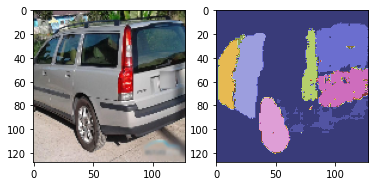

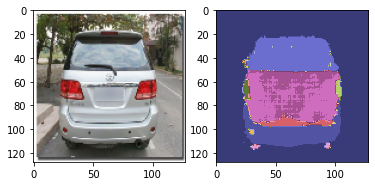

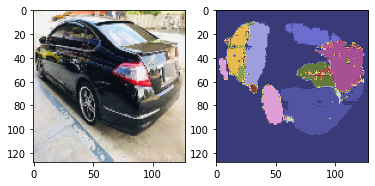

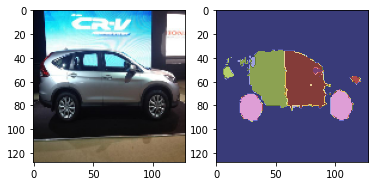

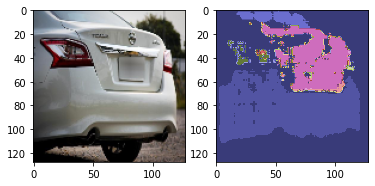

In [25]:
plot_predictions(x_train)

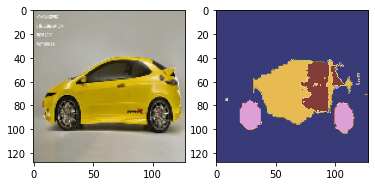

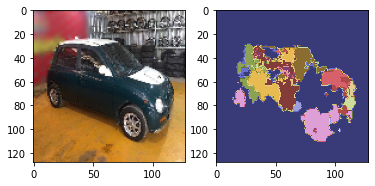

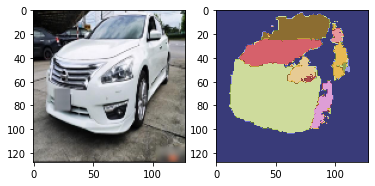

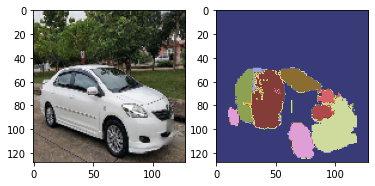

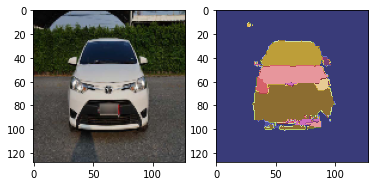

In [26]:
plot_predictions(x_test)

## As we can see, the final outputs are very noisy and inconclusive. In order to clean up the final prediction, we'll use the image segmentation algorithm SLIC to split the prediction into segments and re-color them according to the majority class that was predicted

# Helper fuctions for final prediction

In [27]:
def get_pixel_amnt(img, pixel_val):
    """
    Used the count the amount of pixels for a certain class (i.e wheel) in a prediction
    """
    ret = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] == pixel_val:
                ret += 1
    return ret

def get_arr_mode(x):
    """
    Used to find majority class in segmentations
    """
    values, counts = np.unique(x, return_counts=True)
    m = counts.argmax()
    return values[m], counts[m]

def match_block_to_pred(pred, SLIC_pred):
    """
    Used to find the final overall prediction (by getting the majority class) for a given segment 
    of an image generated by SLIC
    """
    ret_img = np.zeros(SLIC_pred.shape)
    predicted_classes = []
    for val in np.unique(SLIC_pred):
        segment = (SLIC_pred == val)     
        majority_pred = get_arr_mode(pred[segment])[0]
        ret_img[segment] = majority_pred
        predicted_classes.append(rev_category_dict[majority_pred])
    
    return ret_img, set(predicted_classes)

def get_wheel_pred_mask(pred):
    """
    Return a mask for a given prediction where wheel was predicted
    """
    if not get_pixel_amnt(pred, category_dict['wheel']):
        return False
    return pred == category_dict['wheel']

def is_wheel_present(pred):
    """
    Heuristic to decide if a wheel is present in the image:
            "Wheel pixels are more than one precent of the non background pixels"
    """
    not_background_count = int(pred.shape[0] * pred.shape[1]) - get_pixel_amnt(pred, category_dict['_background_'])
    wheel_count = get_pixel_amnt(pred, category_dict['wheel'])
    if not wheel_count:
        return False
    if wheel_count / not_background_count >= 0.01:
        return True
    return False

def get_class_centroid(pred, val):
    """
    Finds the centroid of a given class in a given prediction, mainly used
    to detect if the wheel is to the left\right of the front\back of the car
    """
    y, x = np.where(pred == val)
    return np.mean(x), np.mean(y)




# Functions for final prediction

In [28]:
def get_SLIC_prediction(data, n, segments_param, C_param, sigma_param, is_oop = False):
    """
    Function that recieves an input image, generates a prediction,
    applys SLIC segmentations to the image using given params, cleans up the 
    prediction noise by changing each segment to it's majority class, and returns
    the found classes and final 'cleaned up' prediction
    """
    # Get image prediction
    if is_oop:
        pred = get_prediction(data[n].img)
    else:
        pred = get_prediction(data[n])
    # Find if wheel in prediction
    wheel_flag = is_wheel_present(pred)
    img = plt.cm.tab20b(pred)[:, :, :-1]
    segments_slic = slic(img, n_segments = segments_param, compactness = C_param, sigma = sigma_param,
                     start_label = 1)
    print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
    # Change each segment in noisy prediction to majority class
    final_pred, found_classes = match_block_to_pred(pred, segments_slic)
    # Visualizing results
    if wheel_flag:
        wheel_mask = get_wheel_pred_mask(pred)
        final_pred[wheel_mask] = category_dict['wheel']
        fig, axs = plt.subplots(1, 3, figsize=(15, 15))
        axs[0].imshow(data[n])
        axs[1].imshow(mark_boundaries(img, segments_slic))
        axs[2].imshow(final_pred, cmap = 'tab20b')
    else:
        fig, axs = plt.subplots(1, 3, figsize=(15, 15))
        axs[0].imshow(data[n])
        axs[1].imshow(mark_boundaries(img, segments_slic))
        axs[2].imshow(final_pred, cmap = 'tab20b')

    print(f'Wheel Found : {wheel_flag}')
    return found_classes, wheel_flag, final_pred
 
def get_majority_side(side_1_lst, side_2_lst, pred):
    """
    In case of inconclusive results (e.g both left door and right door were 
    predicted on the same side of the car, we'll count for which class more
    pixels were predicted and return that side)
    """
    side_1_cnt = 0
    side_2_cnt = 0
    for cat in side_1_lst:
        side_1_cnt += get_pixel_amnt(pred, category_dict[cat])
    for cat in side_2_lst:
        side_2_cnt += get_pixel_amnt(pred, category_dict[cat])
    return side_1_lst if side_1_cnt > side_2_cnt else side_2_lst



def get_final_prediction(found_classes, wheel_flag, pred):
    """
    Gets input from get_SLIC_prediction, ruleset to decide which
    of the cars sides are visible
    Algorithm steps:
        1. Count how many classes were predicted from left, right, front and back
           sides.
        2. Decide if front is visible or not by finding which sides count is higher,
           if count is the same, count pixels.
        3. If a wheel was detected, assume that one of the sides is visible and
           calculate the wheels centroid and the centroid of the front class if
           'front_visible == True' else of the back class. After finding the centroid,
           if, for example, the centroid is to the left of the a front class, return
           'front-left'
        4. If wheel was not detected, assume sides are not visible and return front or back
           depending which count is higher 
    """
    print(found_classes)
    front = ['front_bumper', 'front_glass', 'hood']
    back = ['back_bumper', 'back_glass', 'tailgate', 'trunk']
    left = ['front_left_door', 'back_left_door']
    right = ['front_right_door', 'back_right_door']
    front_found = list(set(front) & set(found_classes))
    back_found = list(set(back) & set(found_classes))
    left_found = list(set(left) & set(found_classes))
    right_found = list(set(right) & set(found_classes))
    front_count = len(front_found)
    back_count = len(back_found)
    left_count = len(left_found)
    right_count = len(right_found)
    if front_count + back_count + left_count + right_count == 0 and wheel_flag:
        return 'back'
    print(f'front_count : {front_count}', f'back_count : {back_count}', f'left_count : {left_count}', f'right_count : {right_count}')
    if front_count == back_count and front_count != 0:
        if get_majority_side(front_found, back_found, pred) == front_found:
            front_visible = True
        else:
            front_visible = False
    else :
        front_visible = front_count > back_count 
    if wheel_flag:
        # If majority class is left or right
        if max(front_count, back_count, left_count, right_count) not in [front_count, back_count]: # meaning max group is a left or right
            if left_count == right_count and left_count != 0:
                # Since left and right are very similair, count pixels for each side and decide that way
                if get_majority_side(left_found, right_found, pred) == left_found:
                    return 'left'
                else:
                    return 'right'
            return 'left' if left_count > right_count else 'right'
        elif front_visible:
            # Since front bumper is usually visilbe and in a good postion, default to this center
            if 'front_bumper' in front_found:
                center_class = 'front_bumper'
            # If can't find front bumper, take other center
            else:
                center_class = front_found[0]
            front_centroid, wheel_centroid = get_class_centroid(pred, category_dict[center_class])[0] , get_class_centroid(pred, category_dict['wheel'])[0]
            if front_centroid < wheel_centroid:
                return 'front-left' 
            elif front_centroid >= wheel_centroid:
                return 'front-right'
        else: # front not visible but back is visible
            center_class = back_found[0] 
            back_centroid, wheel_centroid = get_class_centroid(pred, category_dict[center_class])[0] , get_class_centroid(pred, category_dict['wheel'])[0]
            if back_centroid < wheel_centroid:
                return 'back-right' 
            elif back_centroid >= wheel_centroid:
                return 'back-left'
    else: # wheel_flag is false
        return 'front' if front_count > back_count else 'back'
    return 'front'
            

## Example of the algorithm 

SLIC number of segments: 107
Wheel Found : True
{'hood', 'tailgate', 'back_right_door', 'wheel', 'back_right_light', 'back_glass', 'trunk', 'back_left_door', '_background_', 'back_bumper'}
front_count : 1 back_count : 4 left_count : 1 right_count : 1


'back-right'

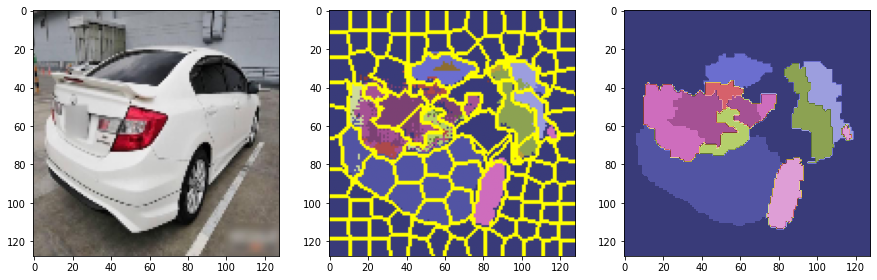

In [32]:
get_final_prediction(*get_SLIC_prediction(x_test, 25, 150, 1, 1))

### Functions\Classes used to assist in re-labeling the images after predicting with our algorithm, the labeling process is not shown in the notebook.


In [30]:
classification_dict = {
     0 : 'front',
     1 : 'front-right',
     2 : 'right',
     3 : 'back-right',
     4 : 'back' ,
     5 : 'back-left',
     6 : 'left' ,
     7 : 'front-left'
}

rev_classification_dict = {v : k for k, v in classification_dict.items()}
rev_classification_dict

{'front': 0,
 'front-right': 1,
 'right': 2,
 'back-right': 3,
 'back': 4,
 'back-left': 5,
 'left': 6,
 'front-left': 7}

In [31]:
class Dataset():
    def __init__(self, data):
        self.data = data
        self.ptr = 0
    
    def add_sample(self, sample):
        self.data.append(sample)

    def show_sample(self, sample_n):
        print(classification_dict.get(self.data[sample_n].classification), sample_n)
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(self.data[sample_n].img)
        axs[1].imshow(self.data[sample_n].label, cmap = 'tab20b')
    
    def iterate_over_samples(self):
        self.show_sample(self.ptr)
        self.ptr += 1
    
    def move_ptr(self, val):
        self.ptr = val
    


class Sample():
    def __init__(self, img, label, classification = None):
        self.img = img
        self.label = label
        self.classification = classification
    
    def show_sample(self):
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(self.img)
        axs[1].imshow(self.label, cmap = 'tab20b')
    
    def reclassify_sample(self, classification):
        self.classification = classification
    



### We'll check the overall accuracy of the algorithm in the DL Project model results notebook.